In [1]:
import pandas as pd 
import pm4py
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#log = pm4py.read_xes("../data/InternationalDeclarations.xes.gz")
#df = pm4py.convert_to_dataframe(log)

## Load Data Preprocessed in ProM

In [4]:
log_time = pm4py.read_xes("../data/International_Declarations_final.xes")
df_time = pm4py.convert_to_dataframe(log_time)
#log_time = pm4py.read_xes('../data/International_Declarations_final.xes')

parsing log, completed traces :: 100%|██████████| 5646/5646 [00:02<00:00, 2231.44it/s]


In [95]:
working_df = df_time
print(len(working_df.index))
working_df.head()

65376
Index(['org:resource', 'org:role', 'remaining_time', 'id', 'concept:name',
       'time:timestamp', 'case:Permit travel permit number',
       'case:DeclarationNumber', 'case:Amount', 'case:RequestedAmount',
       'case:Permit TaskNumber', 'case:Permit BudgetNumber',
       'case:OriginalAmount', 'case:Permit ProjectNumber',
       'case:Permit OrganizationalEntity', 'case:travel permit number',
       'case:Permit RequestedBudget', 'case:id', 'case:Permit ID',
       'case:Permit id', 'case:BudgetNumber', 'case:Permit ActivityNumber',
       'case:AdjustedAmount', 'case:concept:name', 'trip_duration',
       'remaining_time_since_end_trip', 'time_submission'],
      dtype='object')


,org:resource,org:role,remaining_time,id,concept:name,time:timestamp,case:Permit travel permit number,case:DeclarationNumber,case:Amount,case:RequestedAmount,...,case:id,case:Permit ID,case:Permit id,case:BudgetNumber,case:Permit ActivityNumber,case:AdjustedAmount,case:concept:name,trip_duration,remaining_time_since_end_trip,time_submission
0,STAFF MEMBER,EMPLOYEE,4577.514722,rv_travel permit 76455_6,Start trip,2016-10-04 22:00:00+00:00,travel permit number 76456,declaration number 76458,39.664561,39.664561,...,declaration 76457,travel permit 76455,travel permit 76455,budget 144133,activity 46005,39.664561,declaration 76457,NaN,NaN,NaN
1,STAFF MEMBER,EMPLOYEE,4577.514722,rv_travel permit 76455_7,End trip,2016-10-04 22:00:00+00:00,travel permit number 76456,declaration number 76458,39.664561,39.664561,...,declaration 76457,travel permit 76455,travel permit 76455,budget 144133,activity 46005,39.664561,declaration 76457,0.0,4577.514722,NaN
2,STAFF MEMBER,EMPLOYEE,171.978611,st_step 76459_0,Permit SUBMITTED by EMPLOYEE,2017-04-06 11:32:10+00:00,travel permit number 76456,declaration number 76458,39.664561,39.664561,...,declaration 76457,travel permit 76455,travel permit 76455,budget 144133,activity 46005,39.664561,declaration 76457,NaN,NaN,NaN
3,STAFF MEMBER,SUPERVISOR,171.973611,st_step 76460_0,Permit FINAL_APPROVED by SUPERVISOR,2017-04-06 11:32:28+00:00,travel permit number 76456,declaration number 76458,39.664561,39.664561,...,declaration 76457,travel permit 76455,travel permit 76455,budget 144133,activity 46005,39.664561,declaration 76457,NaN,NaN,NaN
4,STAFF MEMBER,EMPLOYEE,147.877500,st_step 76461_0,Declaration SUBMITTED by EMPLOYEE,2017-04-07 11:38:14+00:00,travel permit number 76456,declaration number 76458,39.664561,39.664561,...,declaration 76457,travel permit 76455,travel permit 76455,budget 144133,activity 46005,39.664561,declaration 76457,NaN,NaN,NaN


## Remove all data recorded after "End trip"
* We do not do prefix abstraction in this case, as we are specifically interested in predicting the remaining time after a specific event (End Trip) has happend
* Both for training and test data we thus remove this information
* The posterior feature (remaining time) was already computed in ProM for the "End trip" event

In [84]:
caseIdColumnName = "case:id"
caseIds = working_df[caseIdColumnName].unique()

index_before_End = []

for caseId in caseIds:
    cur_trace = working_df[working_df[caseIdColumnName] == caseId]
    end_trip_time = pd.Timestamp(cur_trace[cur_trace[eventColumnName] == "End trip"]["time:timestamp"].values[0])
    
    for i, event in cur_trace.iterrows():
        if pd.Timestamp(event["time:timestamp"]).replace(tzinfo=None) <= end_trip_time:
            index_before_End.append(i)
        
df_event_before_end = working_df.iloc[index_before_End].copy()
df_event_before_end.head()

,org:resource,org:role,remaining_time,id,concept:name,time:timestamp,case:Permit travel permit number,case:DeclarationNumber,case:Amount,case:RequestedAmount,...,case:id,case:Permit ID,case:Permit id,case:BudgetNumber,case:Permit ActivityNumber,case:AdjustedAmount,case:concept:name,trip_duration,remaining_time_since_end_trip,time_submission
0,STAFF MEMBER,EMPLOYEE,4577.514722,rv_travel permit 76455_6,Start trip,2016-10-04 22:00:00+00:00,travel permit number 76456,declaration number 76458,39.664561,39.664561,...,declaration 76457,travel permit 76455,travel permit 76455,budget 144133,activity 46005,39.664561,declaration 76457,NaN,NaN,NaN
1,STAFF MEMBER,EMPLOYEE,4577.514722,rv_travel permit 76455_7,End trip,2016-10-04 22:00:00+00:00,travel permit number 76456,declaration number 76458,39.664561,39.664561,...,declaration 76457,travel permit 76455,travel permit 76455,budget 144133,activity 46005,39.664561,declaration 76457,0.0,4577.514722,NaN
8,STAFF MEMBER,EMPLOYEE,2705.517222,rv_travel permit 76665_6,Start trip,2016-11-20 23:00:00+00:00,travel permit number 76666,declaration number 76668,346.544903,346.544903,...,declaration 76667,travel permit 76665,travel permit 76665,budget 144054,UNKNOWN,346.544903,declaration 76667,NaN,NaN,NaN
9,STAFF MEMBER,EMPLOYEE,1961.517222,rv_travel permit 76665_7,End trip,2016-12-21 23:00:00+00:00,travel permit number 76666,declaration number 76668,346.544903,346.544903,...,declaration 76667,travel permit 76665,travel permit 76665,budget 144054,UNKNOWN,346.544903,declaration 76667,744.0,1961.517222,NaN
16,STAFF MEMBER,EMPLOYEE,1025.530556,rv_travel permit 73652_6,Start trip,2016-12-07 23:00:00+00:00,travel permit number 73653,declaration number 73655,56.972769,56.972769,...,declaration 73654,travel permit 73652,travel permit 73652,budget 143677,UNKNOWN,56.972769,declaration 73654,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65365,STAFF MEMBER,ADMINISTRATION,1082.501389,st_step 13460_0,Permit APPROVED by ADMINISTRATION,2018-12-10 14:01:39+00:00,travel permit number 13457,declaration number 13459,445.064943,445.064943,...,declaration 13458,travel permit 13456,travel permit 13456,budget 147525,UNKNOWN,445.064943,declaration 13458,NaN,NaN,NaN
65366,STAFF MEMBER,BUDGET OWNER,1064.014444,st_step 13461_0,Permit APPROVED by BUDGET OWNER,2018-12-11 08:30:52+00:00,travel permit number 13457,declaration number 13459,445.064943,445.064943,...,declaration 13458,travel permit 13456,travel permit 13456,budget 147525,UNKNOWN,445.064943,declaration 13458,NaN,NaN,NaN
65367,STAFF MEMBER,SUPERVISOR,900.273056,st_step 13463_0,Permit FINAL_APPROVED by SUPERVISOR,2018-12-18 04:15:21+00:00,travel permit number 13457,declaration number 13459,445.064943,445.064943,...,declaration 13458,travel permit 13456,travel permit 13456,budget 147525,UNKNOWN,445.064943,declaration 13458,NaN,NaN,NaN
65368,STAFF MEMBER,EMPLOYEE,857.528889,rv_travel permit 13456_6,Start trip,2018-12-19 23:00:00+00:00,travel permit number 13457,declaration number 13459,445.064943,445.064943,...,declaration 13458,travel permit 13456,travel permit 13456,budget 147525,UNKNOWN,445.064943,declaration 13458,NaN,NaN,224.974444


## Naive Frequency Based Encoding
Frequency based encoding on all events

ToDo: Encoding only on Events before End Trip

In [92]:
eventColumnName = "concept:name"
eventCategories = df_event_before_end[eventColumnName].unique()
caseIds = df_event_before_end[caseIdColumnName].unique()

frequency_df = pd.DataFrame(index=caseIds, columns=eventCategories).fillna(0)

for cur_case in caseIds:
    cur_eventCategories = df_event_before_end[df_event_before_end[caseIdColumnName] == cur_case][eventColumnName]
    for e in cur_eventCategories:
        frequency_df.loc[cur_case][e] += 1

In [93]:
frequency_df.head()

,Start trip,End trip,Permit SUBMITTED by EMPLOYEE,Permit APPROVED by SUPERVISOR,Permit FINAL_APPROVED by DIRECTOR,Permit FINAL_APPROVED by SUPERVISOR,Permit APPROVED by PRE_APPROVER,Permit REJECTED by SUPERVISOR,Permit REJECTED by EMPLOYEE,Permit REJECTED by MISSING,...,Declaration REJECTED by SUPERVISOR,Permit APPROVED by ADMINISTRATION,Permit APPROVED by BUDGET OWNER,Declaration APPROVED by ADMINISTRATION,Declaration APPROVED by BUDGET OWNER,Declaration REJECTED by ADMINISTRATION,Declaration REJECTED by EMPLOYEE,Permit REJECTED by ADMINISTRATION,Permit REJECTED by BUDGET OWNER,Declaration REJECTED by BUDGET OWNER
declaration 76457,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
declaration 76667,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
declaration 73654,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
declaration 73582,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
declaration 72590,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Add Start time of cases and split data into train and test 

In [42]:
df_time["trip_duration"] = df_time.groupby("case:concept:name")["trip_duration"].transform(lambda x: x.fillna(x.mean()))
df_time["remaining_time_since_end_trip"] = df_time.groupby("case:concept:name")["remaining_time_since_end_trip"].transform(lambda x: x.fillna(x.mean()))
df_time["decl_rejected"] = df_time.groupby("case:concept:name")["concept:name"].transform(lambda x: True if "Declaration REJECTED by ADMINISTRATION" in x.values else False)
df_time["decl_rejected"] = df_time["decl_rejected"].replace({True: 1, False: 0})
df_time["permit_budget_owner"] = df_time.groupby("case:concept:name")["concept:name"].transform(lambda x: True if "Permit APPROVED by BUDGET OWNER" in x.values else False)
df_time["permit_budget_owner"] = df_time["permit_budget_owner"].replace({True: 1, False: 0})

In [44]:
df_time["remaining_time_since_end_trip"].corr(df_time["permit_budget_owner"])

0.0181617125650545

In [20]:
'Declaration REJECTED by ADMINISTRATION' in df_time["concept:name"].values

True

In [37]:
df_time["remaining_time_since_end_trip"].corr(df_time["trip_duration"])

0.047811694303603956

In [10]:
from pm4py.algo.discovery.temporal_profile import algorithm as temporal_profile_discovery
temporal_profile = temporal_profile_discovery.apply(log_time)
temporal_profile

{('Start trip', 'End trip'): (919043.8827725229, 3607987.081416492),
 ('Start trip', 'Permit SUBMITTED by EMPLOYEE'): (2948743.13810111,
  5078300.282669392),
 ('Start trip', 'Permit FINAL_APPROVED by SUPERVISOR'): (2057747.9311023622,
  4182154.8054211214),
 ('Start trip', 'Declaration SUBMITTED by EMPLOYEE'): (2441348.50904462,
  3502989.9969343743),
 ('Start trip',
  'Declaration FINAL_APPROVED by SUPERVISOR'): (2794250.950985615, 3637925.865927677),
 ('Start trip', 'Request Payment'): (3122194.9309027777, 3685091.895178423),
 ('Start trip', 'Payment Handled'): (3424150.0602910602, 3710337.2342768065),
 ('End trip', 'Permit SUBMITTED by EMPLOYEE'): (2628166.619377163,
  4924048.083246778),
 ('End trip', 'Permit FINAL_APPROVED by SUPERVISOR'): (2050775.0537790698,
  4151793.9881941737),
 ('End trip', 'Declaration SUBMITTED by EMPLOYEE'): (1800079.682323513,
  2829832.3700098973),
 ('End trip', 'Declaration FINAL_APPROVED by SUPERVISOR'): (2137872.5087272725,
  2939935.639534619),
 ('

In [17]:
act_count = df_time.groupby(["case:concept:name", "concept:name","remaining_time"], sort=False)
act_count

In [4]:
df_analysis = df.copy()
df_analysis.drop(columns=['case:RequestedAmount', 'case:Permit TaskNumber',
       'case:Permit BudgetNumber', 'case:OriginalAmount',
       'case:Permit ProjectNumber', 'case:concept:name',
       'case:Permit OrganizationalEntity', 'case:travel permit number',
       'case:Permit RequestedBudget', 'case:id', 'case:Permit ID',
       'case:Permit id', 'case:BudgetNumber', 'case:Permit ActivityNumber',
       'case:AdjustedAmount'])

df_analysis.isnull().sum()

id                                  0
org:resource                        0
concept:name                        0
time:timestamp                      0
org:role                            0
case:Permit travel permit number    0
case:DeclarationNumber              0
case:Amount                         0
case:RequestedAmount                0
case:Permit TaskNumber              0
case:Permit BudgetNumber            0
case:OriginalAmount                 0
case:Permit ProjectNumber           0
case:concept:name                   0
case:Permit OrganizationalEntity    0
case:travel permit number           0
case:Permit RequestedBudget         0
case:id                             0
case:Permit ID                      0
case:Permit id                      0
case:BudgetNumber                   0
case:Permit ActivityNumber          0
case:AdjustedAmount                 0
dtype: int64

C:\Users\micha\AppData\Local\Temp\ipykernel_19924\3276152411.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_analysis.corr(),cbar=True,annot=True,cmap='Blues')


<AxesSubplot:>

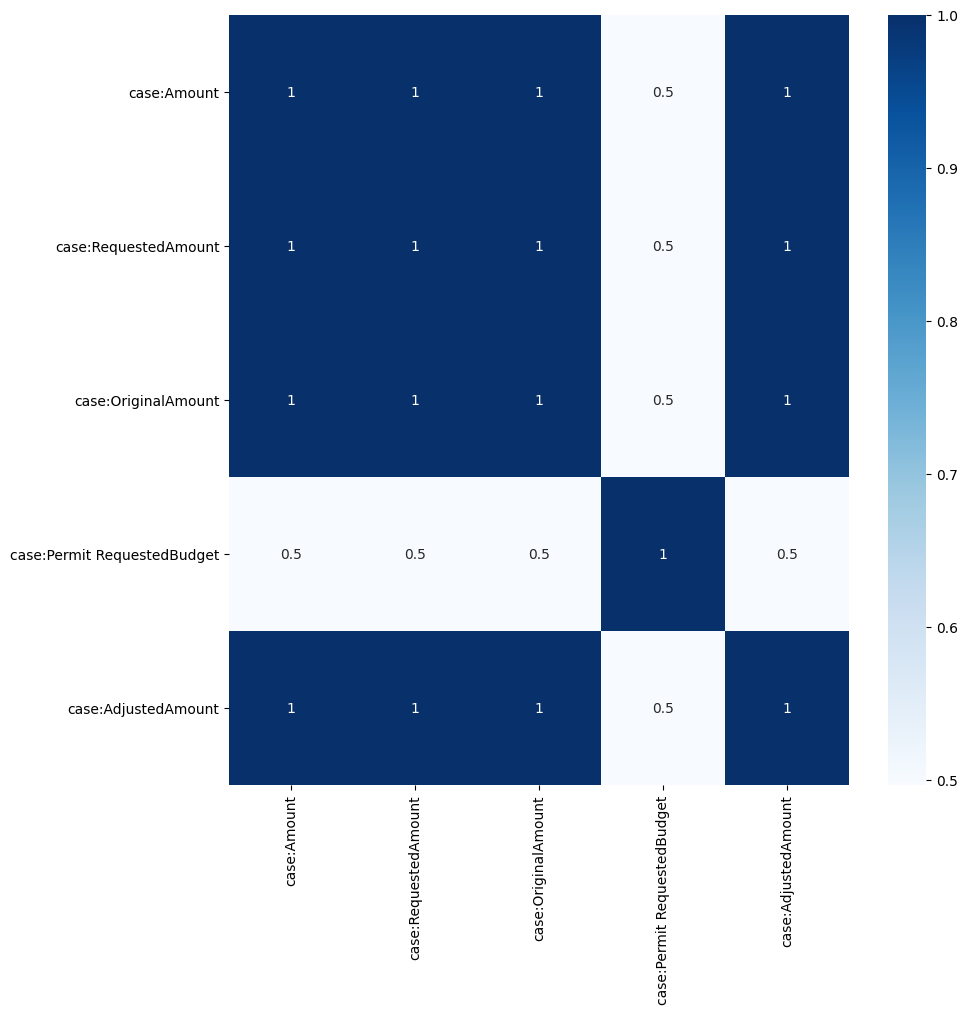

In [5]:
plt.figure(figsize=(10,10))
sns.heatmap(df_analysis.corr(),cbar=True,annot=True,cmap='Blues')

In [28]:
df_time[df_time["case:concept:name"]=="declaration 7194"]

,time_between_events,remaining_time_in_trace,International_remaining_time,remaining_time,org:role,org:resource,id,concept:name,time:timestamp,case:throughputtime,...,case:Permit OrganizationalEntity,case:Permit ProjectNumber,case:OriginalAmount,case:Permit BudgetNumber,case:Permit TaskNumber,case:RequestedAmount,case:Amount,case:DeclarationNumber,case:Permit travel permit number,case:concept:name
14948,0.000000,462.295833,462.295833,462.295833,EMPLOYEE,STAFF MEMBER,st_step 7198_0,Permit SUBMITTED by EMPLOYEE,2018-01-06 10:13:23+00:00,462.295833,...,organizational unit 65455,project 5137,662.163043,budget 2233,task 427,662.163043,662.163043,declaration number 7195,travel permit number 7193,declaration 7194
14949,0.000833,462.295000,462.295000,462.295000,ADMINISTRATION,STAFF MEMBER,st_step 7197_0,Permit APPROVED by ADMINISTRATION,2018-01-06 10:13:26+00:00,462.295833,...,organizational unit 65455,project 5137,662.163043,budget 2233,task 427,662.163043,662.163043,declaration number 7195,travel permit number 7193,declaration 7194
14950,48.690278,413.604722,413.604722,413.604722,SUPERVISOR,STAFF MEMBER,st_step 7196_0,Permit FINAL_APPROVED by SUPERVISOR,2018-01-08 10:54:51+00:00,462.295833,...,organizational unit 65455,project 5137,662.163043,budget 2233,task 427,662.163043,662.163043,declaration number 7195,travel permit number 7193,declaration 7194
14951,180.085833,233.518889,233.518889,233.518889,EMPLOYEE,STAFF MEMBER,rv_travel permit 7192_6,Start trip,2018-01-15 23:00:00+00:00,462.295833,...,organizational unit 65455,project 5137,662.163043,budget 2233,task 427,662.163043,662.163043,declaration number 7195,travel permit number 7193,declaration 7194
14952,72.000000,161.518889,161.518889,161.518889,EMPLOYEE,STAFF MEMBER,rv_travel permit 7192_7,End trip,2018-01-18 23:00:00+00:00,462.295833,...,organizational unit 65455,project 5137,662.163043,budget 2233,task 427,662.163043,662.163043,declaration number 7195,travel permit number 7193,declaration 7194
14953,65.129722,96.389167,96.389167,96.389167,EMPLOYEE,STAFF MEMBER,st_step 7201_0,Declaration SUBMITTED by EMPLOYEE,2018-01-21 16:07:47+00:00,462.295833,...,organizational unit 65455,project 5137,662.163043,budget 2233,task 427,662.163043,662.163043,declaration number 7195,travel permit number 7193,declaration 7194
14954,0.001389,96.387778,96.387778,96.387778,ADMINISTRATION,STAFF MEMBER,st_step 7199_0,Declaration APPROVED by ADMINISTRATION,2018-01-21 16:07:52+00:00,462.295833,...,organizational unit 65455,project 5137,662.163043,budget 2233,task 427,662.163043,662.163043,declaration number 7195,travel permit number 7193,declaration 7194
14955,20.273889,76.113889,76.113889,76.113889,SUPERVISOR,STAFF MEMBER,st_step 7200_0,Declaration FINAL_APPROVED by SUPERVISOR,2018-01-22 12:24:18+00:00,462.295833,...,organizational unit 65455,project 5137,662.163043,budget 2233,task 427,662.163043,662.163043,declaration number 7195,travel permit number 7193,declaration 7194
14956,18.410000,57.703889,57.703889,57.703889,UNDEFINED,SYSTEM,fd_declaration 7194_17,Request Payment,2018-01-23 06:48:54+00:00,462.295833,...,organizational unit 65455,project 5137,662.163043,budget 2233,task 427,662.163043,662.163043,declaration number 7195,travel permit number 7193,declaration 7194
14957,57.703889,0.000000,0.000000,0.000000,UNDEFINED,SYSTEM,fd_declaration 7194_18,Payment Handled,2018-01-25 16:31:08+00:00,462.295833,...,organizational unit 65455,project 5137,662.163043,budget 2233,task 427,662.163043,662.163043,declaration number 7195,travel permit number 7193,declaration 7194


In [29]:
df.columns

Index(['id', 'org:resource', 'concept:name', 'time:timestamp', 'org:role',
       'case:Permit travel permit number', 'case:DeclarationNumber',
       'case:Amount', 'case:RequestedAmount', 'case:Permit TaskNumber',
       'case:Permit BudgetNumber', 'case:OriginalAmount',
       'case:Permit ProjectNumber', 'case:concept:name',
       'case:Permit OrganizationalEntity', 'case:travel permit number',
       'case:Permit RequestedBudget', 'case:id', 'case:Permit ID',
       'case:Permit id', 'case:BudgetNumber', 'case:Permit ActivityNumber',
       'case:AdjustedAmount'],
      dtype='object')